# Script para plotar mapas de calor, a partir de saídas corrigidas do PurpleAir
Desenvolvido por Nicole Laureanti - nlaureanti@gmail.com

Bibliotecas utilizadas: cartopy, scipy

Tarefas: Concatenação de diferentes planilhas corrigidas do PurpleAir (saídas do script_conferedados) + leitura de coordenadas + Cálculo de valores médios, máximos e mínimos horários e diários + Interpolação dos dados utilizados + Plotagem do mapa de calor

Pré-execução: instalar bibliotecas em um ambiente conda

Ref:<https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html>

conda activate PurpleAir

conda install -c conda-forge cartopy

conda install -c conda-forge scipy

conda install -c conda-forge openpyxl


In [1]:
import pandas as pd    # conjunto de funções que se usa para dados em tabela (csv)
#https://pandas.pydata.org/docs/index.html
import matplotlib.pyplot as plt # conjunto de funções que se usa para plotagem 
#https://matplotlib.org/stable/index.html
import numpy as np #para trabalhar com vetores/arrays


import cartopy.crs as ccrs #para introduzir os eixos cartográficos

from scipy.interpolate import griddata as gd #para interpolar os dados
from mpl_toolkits.axes_grid1.inset_locator import inset_axes #para movimentar o eixo que possui a colorbar
from scipy.ndimage.filters import gaussian_filter  #filtro para suavizar o campo pós-interpolação
import matplotlib.transforms as mtransforms # para transformar eixos

/home/nicole/miniconda3/envs/PurpleAir/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Fazendo a leitura das coordenadas

In [2]:
fname_locais='Números_ID_PA.xlsx'
df_locais=pd.read_excel(fname_locais,
                      header=2, index_col=0, usecols=["LOCAL","COORD LAT","COORD LONG"])
print(df_locais)

                       COORD LAT  COORD LONG
LOCAL                                       
IFPR                  -25.586150  -48.563952
RF                    -25.504336  -48.517748
ILHA                  -25.572444  -48.313248
RESERVA DAS ÁGUAS     -25.382222  -48.783611
RESERVA DA GUARICICA  -25.314958  -48.696156
RESERVA DOS PAPAGAIOS -25.223289  -48.454511


# Arquivos de entrada (preparando a execução):

In [3]:
fnames=['Ilha do Mel corrigido.csv',        'Reserva dos Papagaios corrigido.csv',
'Reserva das Águas corrigido.csv',              'RF 20211010-20211016 corrigido.csv',
'Reserva da Guaricica (outside) (-25.314958 -48.696156) Primary Real Time 05_05_2022 05_07_2022-corrigido.csv'
]
pasta_arq='./corrigidos_mapadecalor/'

In [4]:
#Atribuir a coordenada ao nome do arquivo
vetor_lat=[] ;vetor_lon=[]
list_estacao=[]
name_estacao=[]
for loc in range(len(df_locais.index)):
    for f in fnames:
        if df_locais.index[loc] in f.upper(): 
            #condição para verificação do nome do arquivo e atribuição de coordenada
            print(f"loc: {loc} {df_locais.index[loc]} ok {f.upper()}")
            vetor_lat.append(df_locais["COORD LAT"][loc])
            vetor_lon.append(df_locais["COORD LONG"][loc])
            list_estacao.append(f"{pasta_arq}/{f}")
            name_estacao.append(df_locais.index[loc])
print(name_estacao) 
print(vetor_lat)
print(vetor_lon) 


loc: 1 RF ok RF 20211010-20211016 CORRIGIDO.CSV
loc: 2 ILHA  ok ILHA DO MEL CORRIGIDO.CSV
loc: 3 RESERVA DAS ÁGUAS ok RESERVA DAS ÁGUAS CORRIGIDO.CSV
loc: 4 RESERVA DA GUARICICA ok RESERVA DA GUARICICA (OUTSIDE) (-25.314958 -48.696156) PRIMARY REAL TIME 05_05_2022 05_07_2022-CORRIGIDO.CSV
loc: 5 RESERVA DOS PAPAGAIOS ok RESERVA DOS PAPAGAIOS CORRIGIDO.CSV
['RF', 'ILHA ', 'RESERVA DAS ÁGUAS', 'RESERVA DA GUARICICA', 'RESERVA DOS PAPAGAIOS']
[-25.504336, -25.572444, -25.382222, -25.314958, -25.223289]
[-48.517748, -48.313248, -48.783611, -48.696156, -48.454511]


In [5]:
#função para fazer a abertura dos arquivos
def get_data(f):
    try:
        df=pd.read_csv(f,
                      sep=',',header=0, index_col=0,
                       parse_dates=["dates"], na_values='NaN') #arquivo online
    except:
        df=pd.read_csv(f,
                      sep=',',header=0, index_col=0,
                       parse_dates=["UTCDateTime"], na_values='NaN') #arquivo do SD
    return df

In [6]:
#Crio o grid 
dfs=[];xs=[];ys=[]
for i in range(len(name_estacao)):
    print(name_estacao[i])
    xs.append(vetor_lon[i])
    ys.append(vetor_lat[i])
    
    dfs.append(get_data(list_estacao[i]))
    print(xs[i],ys[i])
    #print(loc,xs,ys,name_estacao[i],'\n',dfs[i])
xs, ys = np.array(xs), np.array(ys)  #criar o grid dos dados

RF
-48.517748 -25.504336
ILHA 
-48.313248 -25.572444
RESERVA DAS ÁGUAS
-48.783611 -25.382222
RESERVA DA GUARICICA
-48.696156 -25.314958
RESERVA DOS PAPAGAIOS
-48.454511 -25.223289


In [7]:
#função para interpolar o dado dentro do grid
def interpolar_xy(datax,datay,dataz):
    # Interpolation: Generate grid data of latitude and longitude
    numcols, numrows = 100, 100
    xi = np.linspace(np.min(datax), np.max(datax), numcols)
    yi = np.linspace(np.min(datay), np.max(datay), numrows)
    xi, yi = np.meshgrid(xi, yi)    
     
    zi = gd(
            (datax,datay),
            dataz,
            (xi, yi),
            method='nearest')
    zi = gaussian_filter(zi, 5) 
    return xi, yi, zi    

In [8]:
#Função para plotar o arquivo shapefile
def plot_shape(fname,ax,color='none'):
    from cartopy.io.shapereader import Reader
    """ PLOTS EVERY SHAPE """

    ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),
                  facecolor=color, hatch=None, edgecolor='black')
  

# 1º Plot: mapa da estações

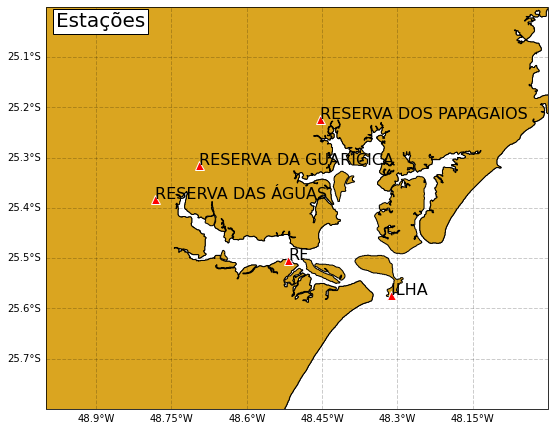

In [9]:
#[ print(f" {name_estacao[i]} {xs[i]} {ys[i]} \n {matrix[i]} ") for i in range(len(name_estacao)) ]

proj = ccrs.PlateCarree() 
#cria a projeção do mapa # https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, ax = plt.subplots(1,figsize=(9,14),
                   subplot_kw=dict(projection=proj),
                   sharex=True,sharey=True,
                   gridspec_kw={'hspace': 0, 'wspace':0}
                      )
for d in range(1):
    ax.set_extent((-49.0, -48.0, -25.80, -25.), crs=proj) #define os limites do mapa
    shpname='shoreNOAA_GSHHG_cutPR_new.shp'
    plot_shape(shpname,ax,'goldenrod')   #chamando a função para plotar o shapefile
    
    [ ax.text(xs[i],ys[i],f"{name_estacao[i]}",
              color='black',fontsize=16) for i in range(len(name_estacao)) ] #plotar os nomes das estações
    [ ax.plot(xs[i],ys[i],color='white',marker='^',
                    markerfacecolor='red',
              markersize=9, transform=proj) for i in range(len(name_estacao)) ] #plotar os marcadores
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

    #Linhas de grade para definir o domínio em latitude e longitude
    gl = ax.gridlines(crs=proj, draw_labels=True,
                                linewidth=1, color='k',
                                alpha=0.2, linestyle='--')        
    gl.right_labels = None
    gl.top_labels = None
    
    #Criar o box com o nome "Estações"
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)            
    ax.text(0.0, 1.0, "Estações", transform=ax.transAxes + trans,
            fontsize=20, verticalalignment='top', 
            bbox=dict(facecolor='1', edgecolor='k', pad=3.0))
    
    plt.savefig('mapa_Estacoes.png',facecolor='white')

# Leitura e organização dos dados 

In [10]:
df_horario=[]
matrix_hourlymean=[]; matrix_hourlymin=[]; matrix_hourlymax=[]
matrix_dailymean=[]; matrix_dailymin=[]; matrix_dailymax=[]
for i in range(len(name_estacao)):
    datai=dfs[i].index[0] #utilize esses dois parmâetros para alterar a data de leitura
    dataf=dfs[i].index[-1]
    date_range=pd.date_range(start=datai,
                    end=dataf,
                    freq="h") #controla o nome dos arquivos/planilhas

    print(f"usando resample em {name_estacao[i]} para {dfs[i].resample('60T')}")

    matrix_hourlymean.append(dfs[i].groupby(dfs[i].index.hour)['pm2.5'].mean())
    matrix_hourlymax.append(dfs[i].groupby(dfs[i].index.hour)['pm2.5'].max())
    matrix_hourlymin.append(dfs[i].groupby(dfs[i].index.hour)['pm2.5'].min())
    
    matrix_dailymean.append(dfs[i].resample('D')['pm2.5'].mean())
    matrix_dailymax.append(dfs[i].resample('D')['pm2.5'].max())
    matrix_dailymin.append(dfs[i].resample('D')['pm2.5'].min())
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html

usando resample em RF para DatetimeIndexResampler [freq=<60 * Minutes>, axis=0, closed=left, label=left, convention=start, origin=start_day]
usando resample em ILHA  para DatetimeIndexResampler [freq=<60 * Minutes>, axis=0, closed=left, label=left, convention=start, origin=start_day]
usando resample em RESERVA DAS ÁGUAS para DatetimeIndexResampler [freq=<60 * Minutes>, axis=0, closed=left, label=left, convention=start, origin=start_day]
usando resample em RESERVA DA GUARICICA para DatetimeIndexResampler [freq=<60 * Minutes>, axis=0, closed=left, label=left, convention=start, origin=start_day]
usando resample em RESERVA DOS PAPAGAIOS para DatetimeIndexResampler [freq=<60 * Minutes>, axis=0, closed=left, label=left, convention=start, origin=start_day]


In [11]:
#Saida para verificação com as planilhas originais
for matrix in [matrix_hourlymean, matrix_dailymean]:
    [ print(f" {name_estacao[i]} {xs[i]} {ys[i]} \n {matrix[i]} ") for i in range(len(name_estacao)) ]



 RF -48.517748 -25.504336 
 UTCDateTime
0     8.363310
1     6.303870
2     6.622916
3     7.579388
4     8.762625
5     9.872880
6     6.925187
7     4.658552
8     5.022527
9     5.869336
10    6.176929
11    6.376047
12    6.328051
13    5.634661
14    5.696427
15    7.221840
16    6.792531
17    5.917443
18    6.187473
19    6.460614
20    7.241941
21    8.059987
22    8.431636
23    7.891295
Name: pm2.5, dtype: float64 
 ILHA  -48.313248 -25.572444 
 dates
0     3.725393
1     3.489758
2     3.880637
3     3.535155
4     3.260472
5     3.619998
6     3.149062
7     3.703383
8     4.204173
9     4.482653
10    4.284421
11    3.763769
12    3.453157
13    5.291428
14    4.432514
15    3.776305
16    4.464348
17    4.832814
18    6.139427
19    5.598213
20    5.211405
21    4.415264
22    5.092327
23    4.285016
Name: pm2.5, dtype: float64 
 RESERVA DAS ÁGUAS -48.783611 -25.382222 
 dates
0     2.757900
1     2.462371
2     2.156647
3     1.966891
4     1.640342
5     1.420373
6     

In [12]:
#Função para plotar o mapa de calor
def plotar_mapa_calor(matriz, nt, c_levels=np.linspace(0,20,11), titulo_str= 'PM2.5', dayformat='%d/%m/%y'):
    proj = ccrs.PlateCarree() #projeção
    if nt<10:
        #quando o número de gáficos é menor do que 10: plota em uma única coluna
        fig, ax = plt.subplots(nt,figsize=(29,34),
                       subplot_kw=dict(projection=proj),
                       sharex=True,sharey=True,
                       gridspec_kw={'hspace': 0, 'wspace':0}
                          )
        for d in range(nt):
            drange=matriz[0].index[d]
            #ax[d].set_extent((-49.0, -48.0, -25.80, -25.), crs=proj)
            shpname='shoreNOAA_GSHHG_cutPR_new.shp'
            plot_shape(shpname,ax[d])  #plotar shapefile

            az=np.empty(len(name_estacao)); #criar matriz para interpolação
            for i in range(len(name_estacao)):
                try:
                    az[i] = matriz[i][d] #recebe dado de cada estação i para o dia d
                except:
                    az[i]=np.nan
    #        az=np.array([matriz[i][d] for i in range(len(name_estacao))])
            print(f"day {d} {drange}",xs.shape,ys.shape,az.shape)
            x,y,z=interpolar_xy(xs,ys,az) #interpola
            
          
            #plotar os valores no gráfico?
            [ ax[d].plot(xs[i],ys[i],label=name_estacao,color='white',marker='o',
                            markerfacecolor='black',markersize=4, transform=proj)
                         for i in range(len(name_estacao)) ] 
            [ ax[d].text(xs[i],ys[i],f"{az[i]:.2f}") for i in range(len(name_estacao)) ]
            
            #Plotar o mapa interpolado:
            p=ax[d].contourf(x,y,z, levels=c_levels, cmap='hot_r', extend='max')    


            plot_shape(shpname,ax[d])  #plotar shapefile
            #ajuste dos grids de coordenadas 
            gl = p.axes.gridlines(crs=proj, draw_labels=True,
                                        linewidth=1, color='k',
                                        alpha=0.2, linestyle='--')        
            gl.right_labels = None
            gl.top_labels = None     
            if d != nt-1:
                gl.bottom_labels = None

            #título plotado no canto superior à esquerda: a data, nesse caso
            trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)            
            ax[d].text(0.0, 1.0, pd.to_datetime(drange).strftime(dayformat), transform=ax[d].transAxes + trans,
                    fontsize='medium', verticalalignment='top', 
                    bbox=dict(facecolor='1', edgecolor='k', pad=3.0))

        #ax[0].set_title(pd.to_datetime(drange).strftime('%D-%M-%Y'),loc='left')
        #colobar:
        cbar_ax = inset_axes(ax[d],
                        width="3%",  
                        height="72%",
                        loc='center right',
                        borderpad=-4,
                       )
        cb = fig.colorbar(p, orientation='vertical', label='$mu$/hora',
                            ticks=c_levels,
                           aspect=30,shrink=.6,pad=3,cax=cbar_ax)
        cb.ax.tick_params(labelsize=15)
        
        #titulo centralizado superior:
        fig.suptitle(titulo_str
                ,fontsize=20,y=.89)
        plt.savefig(f"{titulo_str}.png",facecolor='white')
    else:
        fig, ax = plt.subplots(12,2,figsize=(29,34),
                       subplot_kw=dict(projection=proj),
                       sharex=True,sharey=True,
                       gridspec_kw={'hspace': 0, 'wspace':0}
                          )
        n=0;m=0
        for d in range(nt):
            drange=matriz[0].index[d]
            #ax[n,m].set_extent((-49.0, -48.0, -25.80, -25.), crs=proj) #para alterar os limites do mapa
            shpname='shoreNOAA_GSHHG_cutPR_new.shp'
            plot_shape(shpname,ax[n,m])               

            az=np.empty(len(name_estacao));
            for i in range(len(name_estacao)):
                try:
                    az[i] = matriz[i][d]
                except:
                    az[i]=np.nan
    #        az=np.array([matriz[i][d] for i in range(len(name_estacao))])
            print(f"day {d} {drange}",xs.shape,ys.shape,az.shape)
            x,y,z=interpolar_xy(xs,ys,az)
            
         

            [ ax[n,m].plot(xs[i],ys[i],label=name_estacao,color='white',marker='o',
                            markerfacecolor='black',markersize=4, transform=proj)
                     for i in range(len(name_estacao)) ] 
            [ ax[n,m].text(xs[i],ys[i],f"{az[i]:.2f}") for i in range(len(name_estacao)) ]
            
            p=ax[n,m].contourf(x,y,z, levels=c_levels, cmap='hot_r', extend='max')   
            #opções de cores https://matplotlib.org/stable/tutorials/colors/colormaps.html


            gl = p.axes.gridlines(crs=proj, draw_labels=True,
                                        linewidth=1, color='k',
                                        alpha=0.2, linestyle='--')        
            gl.right_labels = None
            gl.top_labels = None

            #ax[n,m].coastlines()
            plot_shape(shpname,ax[n,m])   
            

            trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)            
            ax[n,m].text(0.0, 1.0, pd.to_datetime(matriz[0].index[d]).strftime(dayformat), transform=ax[n,m].transAxes + trans,
                    fontsize='medium', verticalalignment='top', 
                    bbox=dict(facecolor='1', edgecolor='k', pad=3.0))
            n+=1
            if n!=nt/2:
                gl.bottom_labels = None
            if n>=nt/2: m+=1; n=0
            if m>=nt/2: break

        #ax[0].set_title(pd.to_datetime(drange).strftime('%D-%M-%Y'),loc='left')
        cbar_ax = inset_axes(ax[11,1],
                        width="3%",  
                        height="72%",
                        loc='center right',
                        borderpad=-4,
                       )
        cb = fig.colorbar(p, orientation='vertical', label='$mu$/hora',
                            ticks=c_levels,
                           aspect=30,shrink=.6,pad=3,cax=cbar_ax)
        cb.ax.tick_params(labelsize=15)
        fig.suptitle(titulo_str
                ,fontsize=20,y=.89)
        plt.savefig(f"{titulo_str}.png",facecolor='white')    

Matriz média diária 8
day 0 2021-10-09 00:00:00-03:00 (5,) (5,) (5,)
day 1 2021-10-10 00:00:00-03:00 (5,) (5,) (5,)
day 2 2021-10-11 00:00:00-03:00 (5,) (5,) (5,)
day 3 2021-10-12 00:00:00-03:00 (5,) (5,) (5,)
day 4 2021-10-13 00:00:00-03:00 (5,) (5,) (5,)
day 5 2021-10-14 00:00:00-03:00 (5,) (5,) (5,)
day 6 2021-10-15 00:00:00-03:00 (5,) (5,) (5,)


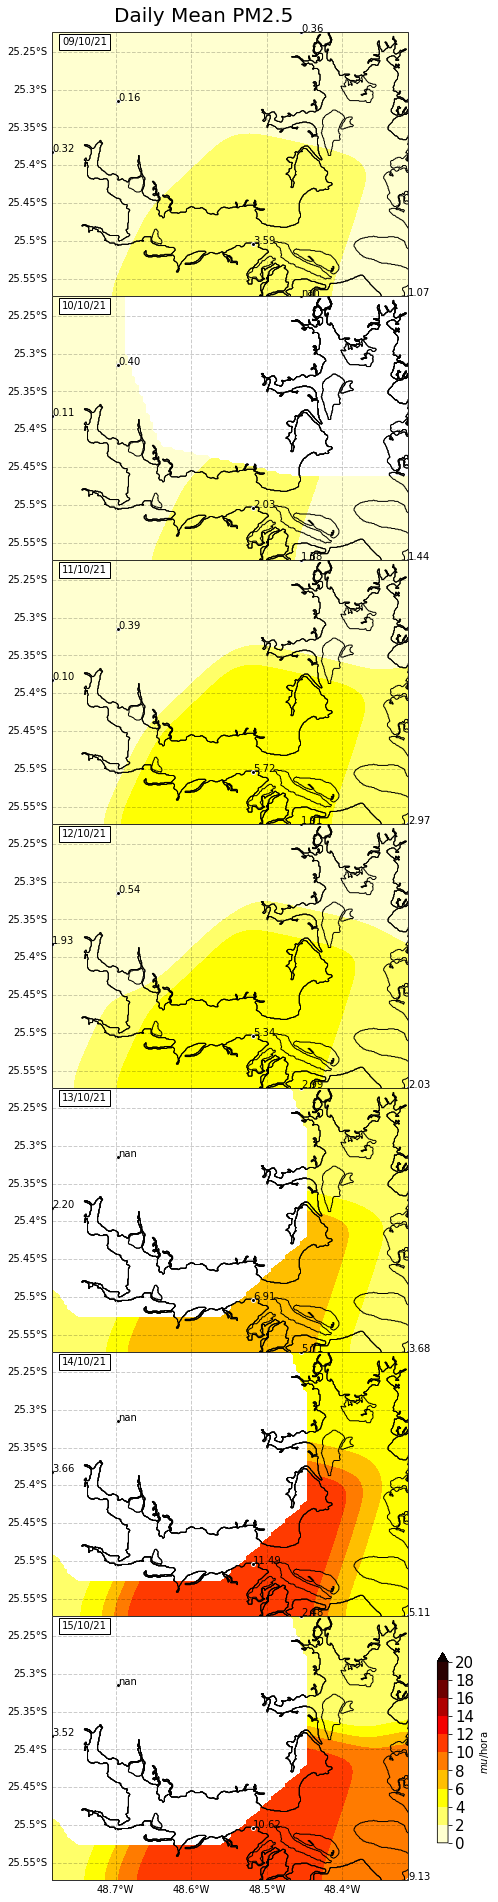

In [13]:

print(f"Matriz média diária {len(matrix_dailymean[0].index)}")

plotar_mapa_calor(matrix_dailymean, len(matrix_dailymean[0].index)-1, dayformat='%d/%m/%y',
                  c_levels=np.linspace(0,20,11), 
                  titulo_str= 'Daily Mean PM2.5')

In [ ]:
print(f"Matriz média horária {len(matrix_hourlymean[0].index)}")
plotar_mapa_calor(matrix_hourlymean, 24, dayformat= '%HH\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\h',
                  c_levels=np.linspace(0,15,11), 
                  titulo_str= 'Hourly Mean PM2.5')

Matriz média horária 24
day 0 0 (5,) (5,) (5,)
day 1 1 (5,) (5,) (5,)
day 2 2 (5,) (5,) (5,)
day 3 3 (5,) (5,) (5,)
day 4 4 (5,) (5,) (5,)
day 5 5 (5,) (5,) (5,)
day 6 6 (5,) (5,) (5,)
day 7 7 (5,) (5,) (5,)
day 8 8 (5,) (5,) (5,)
day 9 9 (5,) (5,) (5,)
day 10 10 (5,) (5,) (5,)
day 11 11 (5,) (5,) (5,)
day 12 12 (5,) (5,) (5,)
day 13 13 (5,) (5,) (5,)
day 14 14 (5,) (5,) (5,)
day 15 15 (5,) (5,) (5,)
day 16 16 (5,) (5,) (5,)
day 17 17 (5,) (5,) (5,)
day 18 18 (5,) (5,) (5,)
day 19 19 (5,) (5,) (5,)
day 20 20 (5,) (5,) (5,)
day 21 21 (5,) (5,) (5,)
day 22 22 (5,) (5,) (5,)
day 23 23 (5,) (5,) (5,)


Matriz max horária 24
day 0 0 (5,) (5,) (5,)
day 1 1 (5,) (5,) (5,)
day 2 2 (5,) (5,) (5,)
day 3 3 (5,) (5,) (5,)
day 4 4 (5,) (5,) (5,)
day 5 5 (5,) (5,) (5,)
day 6 6 (5,) (5,) (5,)
day 7 7 (5,) (5,) (5,)
day 8 8 (5,) (5,) (5,)
day 9 9 (5,) (5,) (5,)
day 10 10 (5,) (5,) (5,)
day 11 11 (5,) (5,) (5,)
day 12 12 (5,) (5,) (5,)
day 13 13 (5,) (5,) (5,)
day 14 14 (5,) (5,) (5,)
day 15 15 (5,) (5,) (5,)
day 16 16 (5,) (5,) (5,)
day 17 17 (5,) (5,) (5,)
day 18 18 (5,) (5,) (5,)
day 19 19 (5,) (5,) (5,)
day 20 20 (5,) (5,) (5,)
day 21 21 (5,) (5,) (5,)
day 22 22 (5,) (5,) (5,)
day 23 23 (5,) (5,) (5,)


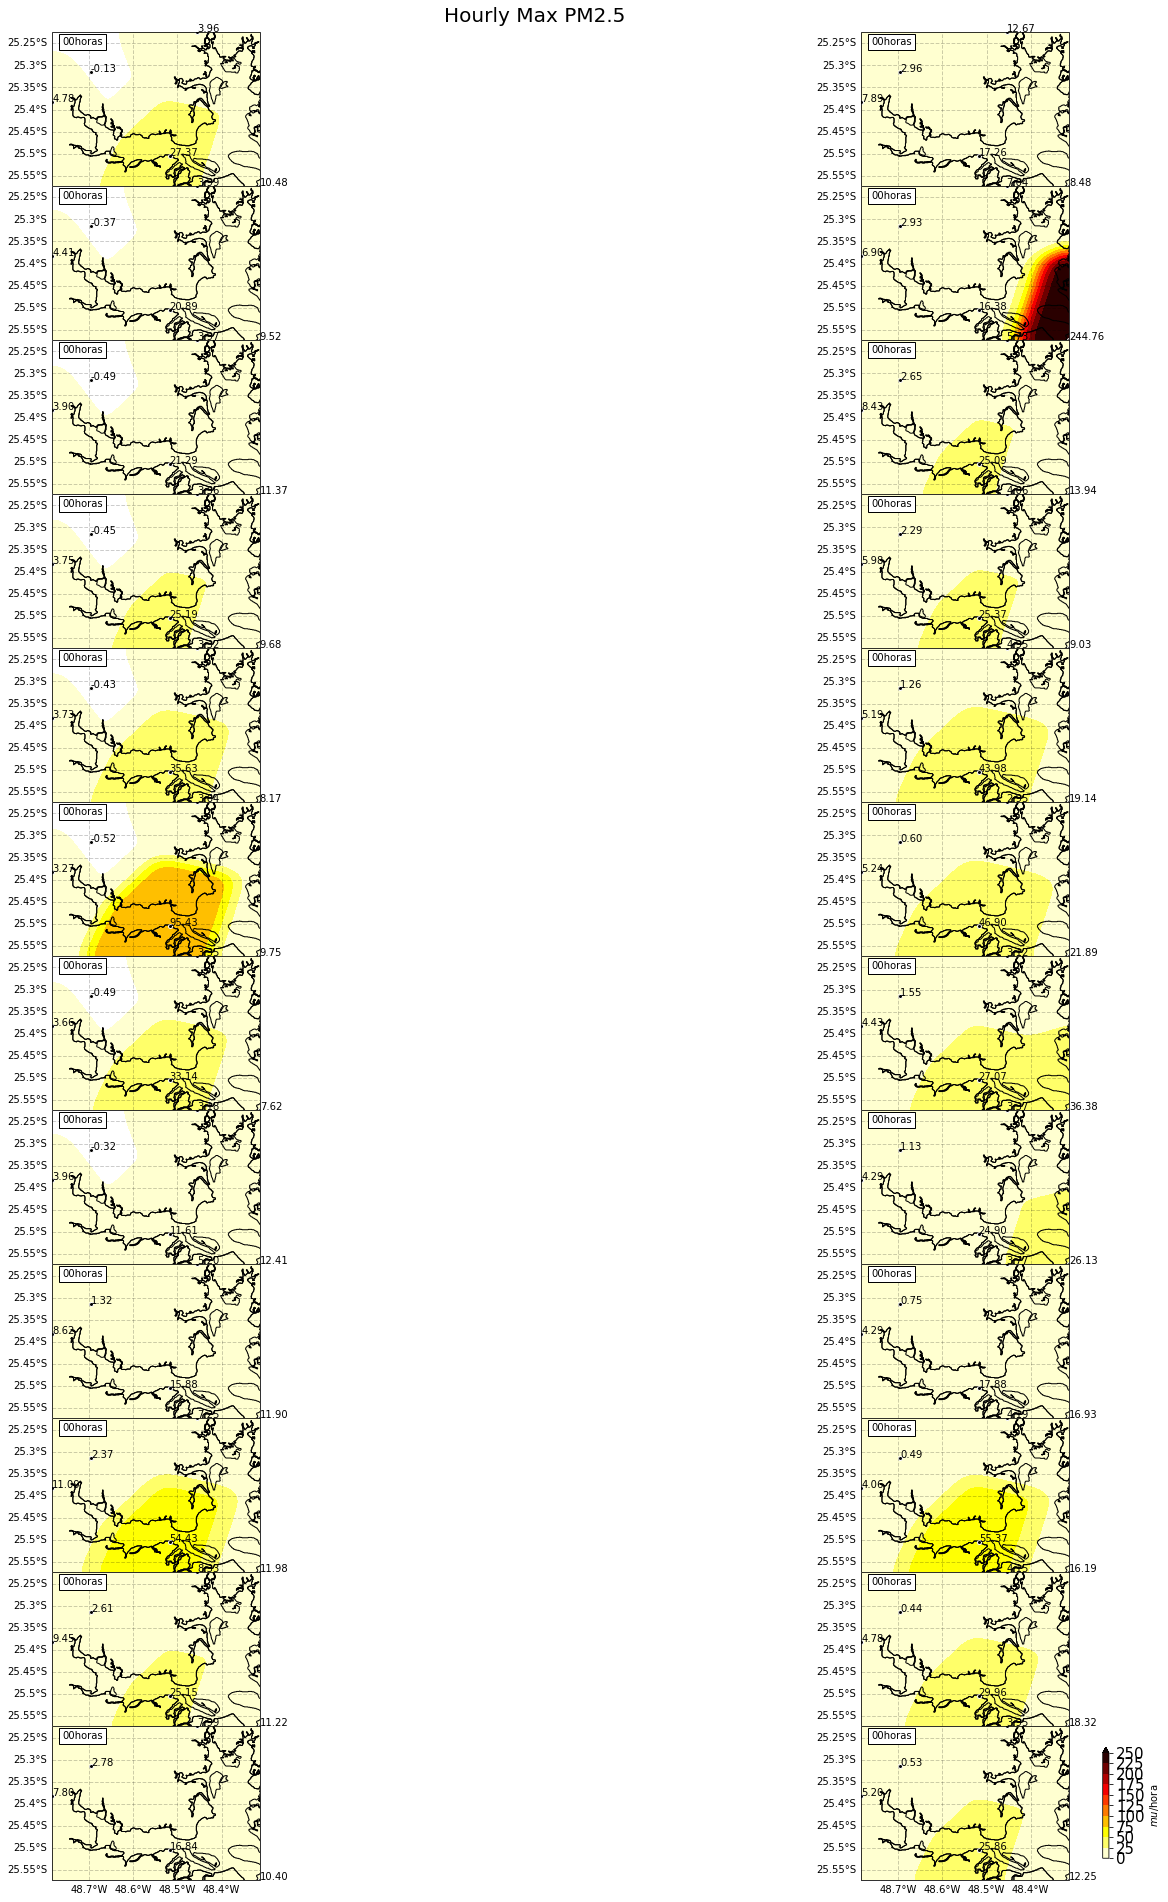

In [15]:
print(f"Matriz max horária {len(matrix_hourlymax[0].index)}")
plotar_mapa_calor(matrix_hourlymax, 24, dayformat= '%Hhoras',
                  c_levels=np.linspace(0,250,11), 
                  titulo_str= 'Hourly Max PM2.5')

Matriz máximo horário 8
day 0 2021-10-09 00:00:00-03:00 (5,) (5,) (5,)
day 1 2021-10-10 00:00:00-03:00 (5,) (5,) (5,)
day 2 2021-10-11 00:00:00-03:00 (5,) (5,) (5,)
day 3 2021-10-12 00:00:00-03:00 (5,) (5,) (5,)
day 4 2021-10-13 00:00:00-03:00 (5,) (5,) (5,)
day 5 2021-10-14 00:00:00-03:00 (5,) (5,) (5,)
day 6 2021-10-15 00:00:00-03:00 (5,) (5,) (5,)
day 7 2021-10-16 00:00:00-03:00 (5,) (5,) (5,)


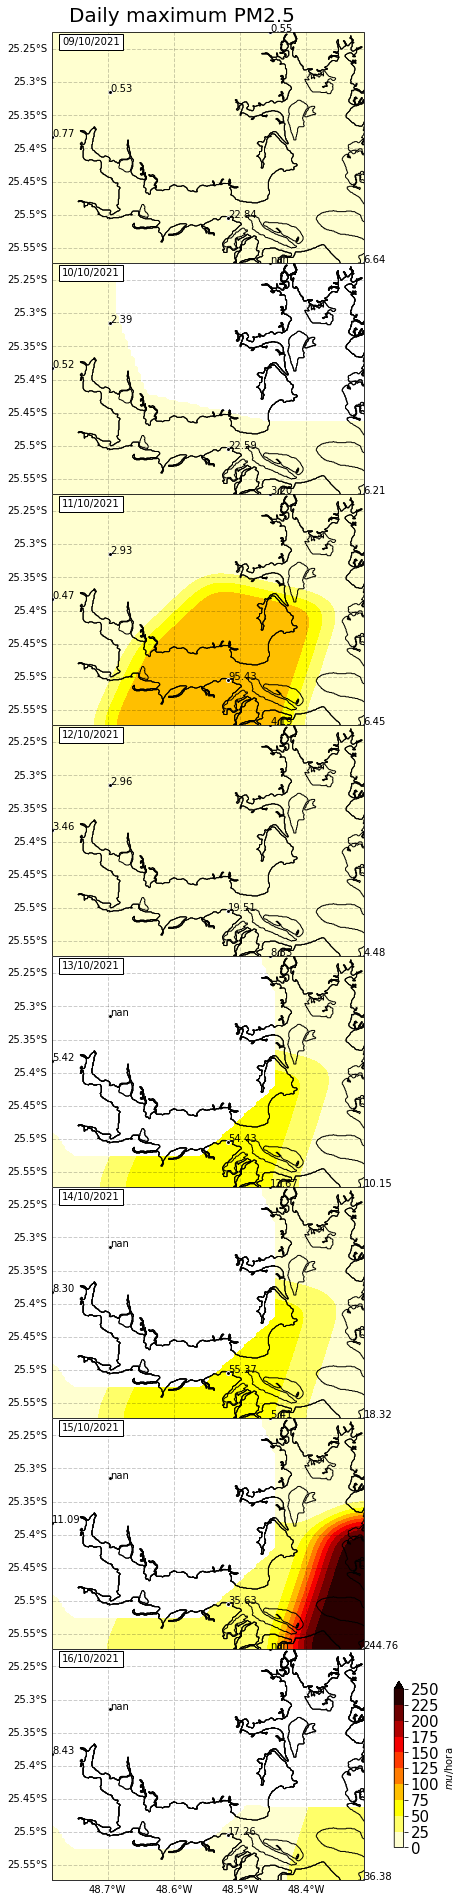

In [16]:
print(f"Matriz máximo horário {len(matrix_dailymax[0].index)}")
plotar_mapa_calor(matrix_dailymax, len(matrix_dailymax[0].index), 
                  c_levels=np.linspace(0,250,11), dayformat='%d/%m/%Y',
                  titulo_str= 'Daily maximum PM2.5')

In [17]:
matrix_dailymax.plot()

AttributeError: 'list' object has no attribute 'plot'